# 2.3.1 파이썬 말뭉치 전처리하기

In [1]:
text = "You say goodbye and I say hello."

In [2]:
text = text.lower()
text = text.replace('.', ' .')
text

'you say goodbye and i say hello .'

In [3]:
words = text.split(' ')
words

['you', 'say', 'goodbye', 'and', 'i', 'say', 'hello', '.']

In [4]:
word_to_id = {}
id_to_word = {}

for word in words:
    if word not in word_to_id:
        new_id = len(word_to_id)
        word_to_id[word] = new_id
        id_to_word[new_id] = word
# 중복 제거

print(word_to_id)
print(id_to_word)

{'you': 0, 'say': 1, 'goodbye': 2, 'and': 3, 'i': 4, 'hello': 5, '.': 6}
{0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}


In [5]:
import numpy as np

corpus = [word_to_id[w] for w in words]
worpus = np.array(corpus)
corpus

[0, 1, 2, 3, 4, 1, 5, 6]

In [6]:
def preprocess(text):
    text = text.lower()
    text = text.replace('.', ' .')
    words = text.split(' ')

    word_to_id = {}
    id_to_word = {}

    for word in words:
        if word not in word_to_id:
            new_id = len(word_to_id)
            word_to_id[word] = new_id
            id_to_word[new_id] = word
    corpus = np.array([word_to_id[w] for w in words])

    return corpus, word_to_id, id_to_word

In [7]:
text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)

# 2.3.4 Co-occurrence matrix (동시 발생 행렬)

In [8]:
import numpy as np

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
print(corpus)
print(id_to_word)


[0 1 2 3 4 1 5 6]
{0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}


In [9]:
C = np.array([
    [0,1,0,0,0,0,0],
    [1,0,1,0,1,1,0],
    [0,1,0,1,0,0,0],
    [0,0,1,0,1,0,0],
    [0,1,0,1,0,0,0],
    [0,1,0,0,0,0,1],
    [0,0,0,0,0,1,0]
])

print(C[0])
print(C[4])
print(C[word_to_id['goodbye']])


[0 1 0 0 0 0 0]
[0 1 0 1 0 0 0]
[0 1 0 1 0 0 0]


In [10]:
def create_co_matrix(corpus, vocab_size, window_size = 1):
    corpus_size = len(corpus)
    co_matrix = np.zeros((vocab_size, vocab_size), dtype = np.int32)

    for idx, word_id in enumerate(corpus):
        for i in range(1, window_size + 1):
            left_idx = idx - i
            right_idx = idx + i

            if left_idx >= 0:
                left_word_id = corpus[left_idx]
                co_matrix[word_id, left_word_id] +=1

            if right_idx < corpus_size:
                right_word_id = corpus[right_idx]
                co_matrix[word_id, right_word_id] +=1

    return co_matrix    

In [11]:
create_co_matrix(corpus, len(word_to_id))

array([[0, 1, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 1, 1, 0],
       [0, 1, 0, 1, 0, 0, 0],
       [0, 0, 1, 0, 1, 0, 0],
       [0, 1, 0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1, 0]], dtype=int32)

# 2.3.5 벡터간 유사

In [12]:
def cos_similarity(x,y, eps= 1e-8):
    nx = x / (np.sqrt(np.sum(x**2))+ eps)
    ny = y / (np.sqrt(np.sum(y**2))+ eps)
    return np.dot(nx,ny)

In [13]:
text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(word_to_id)
C = create_co_matrix(corpus, vocab_size)

c0 = C[word_to_id['you']]
c1 = C[word_to_id['i']]

print(cos_similarity(c0,c1))

0.7071067691154799


# 2.3.6 유사 단어의 랭킹표

In [14]:
def most_similar(query, word_to_id, id_to_word, word_matrix, top = 5):
    if query not in word_to_id:
        print('%s(을)를 찾을 수 없습니다.' % query)
        return

    print('\n[query]' + query)
    query_id = word_to_id[query]
    query_vec = word_matrix[query_id]

    vocab_size = len(id_to_word)
    similarity = np.zeros(vocab_size)
    for i in range(vocab_size):
        similarity[i] = cos_similarity(word_matrix[i], query_vec)


    count = 0

    for i in (-1 * similarity).argsort():
        if id_to_word[i] == query:
            continue
        print('%s: %s' %(id_to_word[i], similarity[i]))

        count +=1
        if count >= top:
            return 
                          

In [15]:
text = 'You say goodbye and I say hello.'

corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(word_to_id)

C = create_co_matrix(corpus, vocab_size)

most_similar('you', word_to_id, id_to_word, C, top=5)


[query]you
goodbye: 0.7071067691154799
i: 0.7071067691154799
hello: 0.7071067691154799
say: 0.0
and: 0.0


# 2.4.1 상호정보량
## Pointwise Mutual Information (점별 상호정보량)



In [16]:
def ppmi(C, verbose = False, eps = 1e-8):
    M = np.zeros_like(C, dtype = np.float32)
    N = np.sum(C)
    S = np.sum(C, axis = 0)
    total = C.shape[0] * C.shape[1]
    cnt = 0

    for i in range(C.shape[0]): 
        for j in range(C.shape[1]):
            pmi = np.log2(C[i,j] * N / (S[i]*S[j]) + eps)
            M[i,j] = max(0, pmi)
            #print(f"i = {i}, j = {j}")
            if verbose :
                cnt += 1
                #print(cnt)
                if cnt % (total//100) == 0:
                    print('%.1f%% 완료' %(100*cnt/total))
    return M
# 이중 포문 총 1억번 돌아감.

In [17]:
import pandas as pd

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(word_to_id)
C = create_co_matrix(corpus, vocab_size)
W = ppmi(C)

C = pd.DataFrame(C, index = word_to_id.keys(), columns = word_to_id.keys())
W = pd.DataFrame(W, index = word_to_id.keys(), columns = word_to_id.keys())

W = W.round(3)


np.set_printoptions(precision = 3)
print('co-occurrence matrix')
print(C)
print('-'*50)
print('PPMI')
print(W)

co-occurrence matrix
         you  say  goodbye  and  i  hello  .
you        0    1        0    0  0      0  0
say        1    0        1    0  1      1  0
goodbye    0    1        0    1  0      0  0
and        0    0        1    0  1      0  0
i          0    1        0    1  0      0  0
hello      0    1        0    0  0      0  1
.          0    0        0    0  0      1  0
--------------------------------------------------
PPMI
           you    say  goodbye    and      i  hello      .
you      0.000  1.807    0.000  0.000  0.000  0.000  0.000
say      1.807  0.000    0.807  0.000  0.807  0.807  0.000
goodbye  0.000  0.807    0.000  1.807  0.000  0.000  0.000
and      0.000  0.000    1.807  0.000  1.807  0.000  0.000
i        0.000  0.807    0.000  1.807  0.000  0.000  0.000
hello    0.000  0.807    0.000  0.000  0.000  0.000  2.807
.        0.000  0.000    0.000  0.000  0.000  2.807  0.000


# 2.4.3 SVD에 의한 차원 감

In [18]:
import numpy as np
import matplotlib.pyplot as plt

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(word_to_id)
C = create_co_matrix(corpus, vocab_size)
W = ppmi(C)

U, S, V = np.linalg.svd(W)

print(C[0])
print(W[0])
print(U[0])
print(U[0, :2])

[0 1 0 0 0 0 0]
[0.    1.807 0.    0.    0.    0.    0.   ]
[ 3.409e-01 -1.110e-16 -1.205e-01 -4.163e-16 -9.323e-01 -1.110e-16
 -2.426e-17]
[ 3.409e-01 -1.110e-16]


In [19]:
print(W)

[[0.    1.807 0.    0.    0.    0.    0.   ]
 [1.807 0.    0.807 0.    0.807 0.807 0.   ]
 [0.    0.807 0.    1.807 0.    0.    0.   ]
 [0.    0.    1.807 0.    1.807 0.    0.   ]
 [0.    0.807 0.    1.807 0.    0.    0.   ]
 [0.    0.807 0.    0.    0.    0.    2.807]
 [0.    0.    0.    0.    0.    2.807 0.   ]]


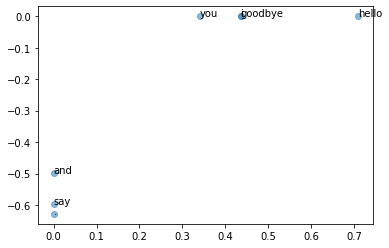

In [20]:
for word, word_id in word_to_id.items():
    plt.annotate(word, (U[word_id, 0], U[word_id, 1]))

plt.scatter(U[:,0], U[:,1], alpha = 0.5)
plt.show()

# 2.4.4 PTB 데이터

In [21]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [22]:
%cd /content/drive/MyDrive/Colab Notebooks
from dataset import ptb 

/content/drive/MyDrive/Colab Notebooks


In [24]:
corpus, word_to_id, id_to_word = ptb.load_data('train')

Done


In [25]:
print('말뭉치 크기 : ', len(corpus))
print('corpus[:30] : ', corpus[:30])
print()
print('id_to_word[0] : ', id_to_word[0])
print('id_to_word[1] : ', id_to_word[1])
print('id_to_word[2] : ', id_to_word[2])
print()
print("word_to_id['car'] : ", word_to_id['car'])
print("word_to_id['happy'] : ", word_to_id['happy'])
print("word_to_id['lexus'] : ", word_to_id['lexus'])




말뭉치 크기 :  929589
corpus[:30] :  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]

id_to_word[0] :  aer
id_to_word[1] :  banknote
id_to_word[2] :  berlitz

word_to_id['car'] :  3856
word_to_id['happy'] :  4428
word_to_id['lexus'] :  7426


# 2.4.5 PTB 데이터셋 평가


In [27]:
window_size = 2
wordvec_size = 100

corpus, word_to_id, id_to_word = ptb.load_data('train')
vocab_size = len(word_to_id)
print('동시 발생 수 계산 ...')
C = create_co_matrix(corpus, vocab_size, window_size)
print("PPMI 계산 ...")
W = ppmi(C, verbose = True)

print('SVD 계산 ...')

try:
    from sklearn.utils.extmath import randomized_svd
    U, S, V = randomized_svd(W, n_components = wordvec_size, n_iter = 5, random_state = None)

except ImportError:
    U, S, V = np.lionalg.svd(W)


word_vecs = U[:, :wordvec_size]

print("PPMI결과를 SVD 한 후 유사도 계산")

querys = ['you', 'year', 'car', 'toyota']
for query in querys:
    most_similar(query, word_to_id, id_to_word, word_vecs, top=5)


try:
    from sklearn.utils.extmath import randomized_svd
    U, S, V = randomized_svd(C, n_components = wordvec_size, n_iter = 5, random_state = None)

except ImportError:
    U, S, V = np.lionalg.svd(C)



word_vecs = U[:, :wordvec_size]



print("Co-oc-matrix를 svd 한 후 유사도 계산")

for query in querys:
    most_similar(query, word_to_id, id_to_word, word_vecs, top=5)




동시 발생 수 계산 ...
PPMI 계산 ...
1.0% 완료
2.0% 완료
3.0% 완료
4.0% 완료
5.0% 완료
6.0% 완료
7.0% 완료
8.0% 완료
9.0% 완료
10.0% 완료
11.0% 완료
12.0% 완료
13.0% 완료
14.0% 완료
15.0% 완료
16.0% 완료
17.0% 완료
18.0% 완료
19.0% 완료
20.0% 완료
21.0% 완료
22.0% 완료
23.0% 완료
24.0% 완료
25.0% 완료
26.0% 완료
27.0% 완료
28.0% 완료
29.0% 완료
30.0% 완료
31.0% 완료
32.0% 완료
33.0% 완료
34.0% 완료
35.0% 완료
36.0% 완료
37.0% 완료
38.0% 완료
39.0% 완료
40.0% 완료
41.0% 완료
42.0% 완료
43.0% 완료
44.0% 완료
45.0% 완료
46.0% 완료
47.0% 완료
48.0% 완료
49.0% 완료
50.0% 완료
51.0% 완료
52.0% 완료
53.0% 완료
54.0% 완료
55.0% 완료
56.0% 완료
57.0% 완료
58.0% 완료
59.0% 완료
60.0% 완료
61.0% 완료
62.0% 완료
63.0% 완료
64.0% 완료
65.0% 완료
66.0% 완료
67.0% 완료
68.0% 완료
69.0% 완료
70.0% 완료
71.0% 완료
72.0% 완료
73.0% 완료
74.0% 완료
75.0% 완료
76.0% 완료
77.0% 완료
78.0% 완료
79.0% 완료
80.0% 완료
81.0% 완료
82.0% 완료
83.0% 완료
84.0% 완료
85.0% 완료
86.0% 완료
87.0% 완료
88.0% 완료
89.0% 완료
90.0% 완료
91.0% 완료
92.0% 완료
93.0% 완료
94.0% 완료
95.0% 완료
96.0% 완료
97.0% 완료
98.0% 완료
99.0% 완료
100.0% 완료
SVD 계산 ...
PPMI결과를 SVD 한 후 유사도 계산

[query]you
i: 0.65430748462677
we: 0.646633207